## **Introduction to Artificial Intelligence - Computer Assignment 5 - Convolutional Neural Networks**

## *Amin Aghakasiri*
## *Student ID : 810101381*

In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.optim as optim

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Config

## Model training config

In [19]:
LEARNING_RATE = 4e-3
WEIGHT_DECAY = 1e-3
BATCH_SIZE = 64
EPOCHS = 400
INPUT_DIM = 300
NUM_CLASSES = 2
SEQUENCE_LEN = 64
CNN_FILTERS = 64
MOMENTUM = 0.9

In [20]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

## Load Data

In [21]:
df = pd.read_csv("./twitter-suicidal-data.csv")
df.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


## Part 1 : Data Preprocessing

In [22]:
import nltk
import emoji
import re
import string

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

[nltk_data] Downloading package stopwords to /home/amin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/amin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/amin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/amin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [23]:
def convert_emoji_to_text(text):
    return emoji.replace_emoji(text, replace=' ')

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    # 1. Lowercase the text
    text = text.lower()

    # 2. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 3. Remove numbers
    text = re.sub(r'\d+', '', text)

    # 4. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 5. Remove usernames
    text = re.sub(r'@\w+', '', text)

    # 6. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # 7. Convert emojis to text
    text = convert_emoji_to_text(text)

    # 8. Remove non-word characters (keeping only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 9. Lemmatization and tokenization of the text
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(word, nltk_pos_tagger(tag)) for word, tag in pos_tags]

    # 10. Remove stopwords
    tokens = [word for word in tokens if word not in stopwords]

    return tokens


In [24]:
pre_df = df.copy()
# Apply the preprocessing function to each tweet and create a new DataFrame
df['tweet'] = df['tweet'].apply(preprocess_data)

In [25]:
print("Samples before preprocessing:")
print(pre_df.head(),end="\n\n")
print("Samples after preprocessing:")
print(df.head())

Samples before preprocessing:
                                               tweet  intention
0  my life is meaningless i just want to end my l...          1
1  muttering i wanna die to myself daily for a fe...          1
2  work slave i really feel like my only purpose ...          1
3  i did something on the 2 of october i overdose...          1
4  i feel like no one cares i just want to die ma...          1

Samples after preprocessing:
                                               tweet  intention
0  [life, meaningless, want, end, life, badly, li...          1
1  [mutter, wan, na, die, daily, month, feel, wor...          1
2  [work, slave, really, feel, like, purpose, lif...          1
3  [something, october, overdose, felt, alone, ho...          1
4  [feel, like, one, care, want, die, maybe, feel...          1


Intention 1: Min = 0, Max = 2129, Average = 73.63
Intention 0: Min = 0, Max = 38, Average = 8.95
All Intentions: Min = 0, Max = 2129, Average = 37.31


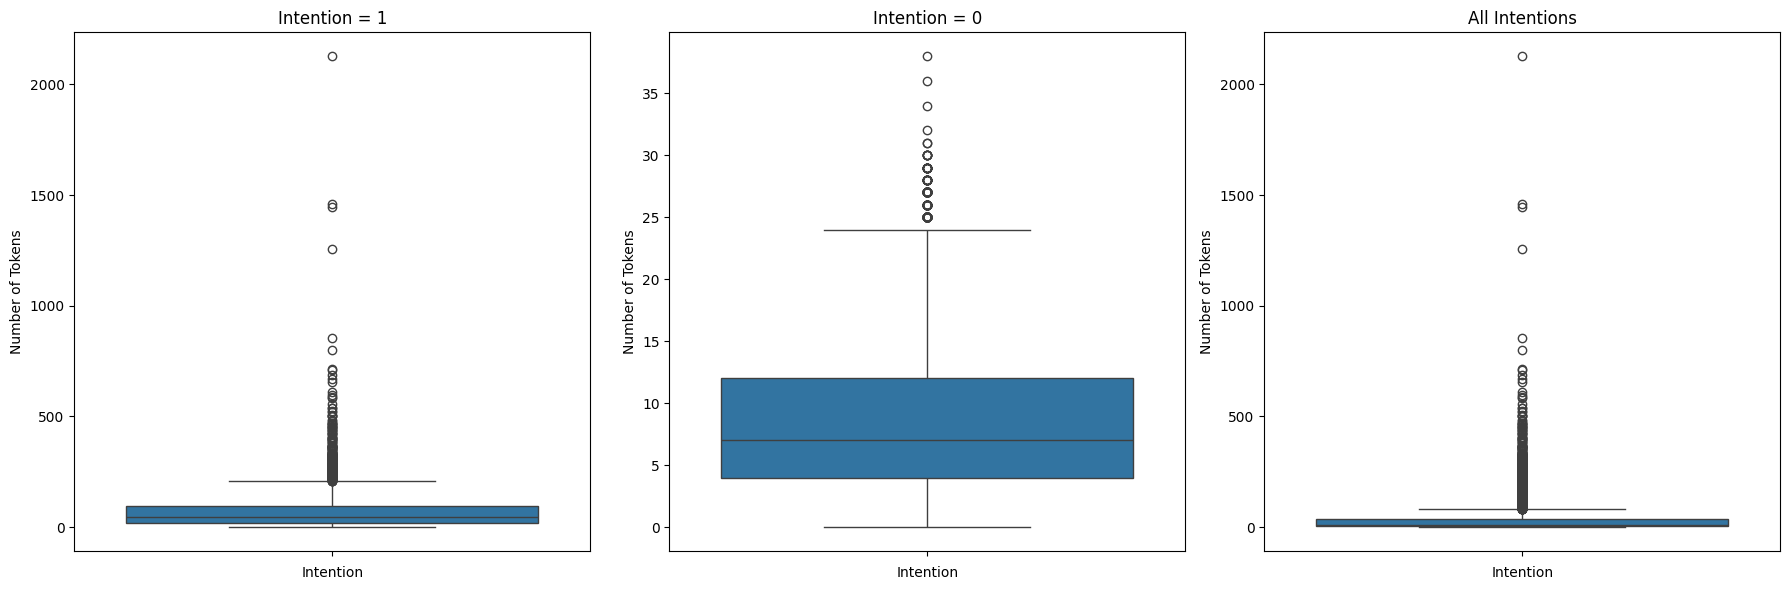

In [26]:
df['num_tokens'] = df['tweet'].apply(len)
df_intention_1 = df[df['intention'] == 1]
df_intention_0 = df[df['intention'] == 0]
stats = {
    'Intention 1': {
        'min': df_intention_1['num_tokens'].min(),
        'max': df_intention_1['num_tokens'].max(),
        'average': df_intention_1['num_tokens'].mean()
    },
    'Intention 0': {
        'min': df_intention_0['num_tokens'].min(),
        'max': df_intention_0['num_tokens'].max(),
        'average': df_intention_0['num_tokens'].mean()
    },
    'All Intentions': {
        'min': df['num_tokens'].min(),
        'max': df['num_tokens'].max(),
        'average': df['num_tokens'].mean()
    }
}

for key, value in stats.items():
    print(f"{key}: Min = {value['min']}, Max = {value['max']}, Average = {value['average']:.2f}")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(ax=axes[0], y=df_intention_1['num_tokens'])
axes[0].set_title('Intention = 1')
axes[0].set_xlabel('Intention')
axes[0].set_ylabel('Number of Tokens')

sns.boxplot(ax=axes[1], y=df_intention_0['num_tokens'])
axes[1].set_title('Intention = 0')
axes[1].set_xlabel('Intention')
axes[1].set_ylabel('Number of Tokens')

sns.boxplot(ax=axes[2], y=df['num_tokens'])
axes[2].set_title('All Intentions')
axes[2].set_xlabel('Intention')
axes[2].set_ylabel('Number of Tokens')

plt.tight_layout()

plt.show()

### Question 1 : What are advantages and disadvantages of converting text to lowercase and why are we doing that?

Converting text to lowercase is a common preprocessing step in natural language processing (NLP) tasks. Here are the advantages and disadvantages of converting text to lowercase:

**Advantages:**

1. **Normalization**: Lowercasing helps in normalizing the text by ensuring that the same word written in different cases (e.g., "Hello", "hello", "HELLO") is treated as the same word. This simplifies the text representation and reduces vocabulary size.
   
2. **Consistency**: Lowercasing ensures consistency in the text data, making it easier for downstream tasks such as tokenization, stemming, and lemmatization. It reduces the complexity of the text by eliminating variations due to case differences.

3. **Improved Generalization**: Lowercasing can improve the generalization ability of machine learning models. By treating words irrespective of their case, the model can learn more robust patterns and generalize better to unseen data.

4. **Reduced Sparsity**: Lowercasing helps in reducing the sparsity of the feature space, especially in tasks like text classification or sentiment analysis. It aggregates similar words and reduces the number of unique tokens, which can lead to more efficient model training.

**Disadvantages:**

1. **Loss of Information**: Lowercasing may result in the loss of information, especially in languages where capitalization carries semantic meaning.

2. **Preservation of Acronyms and Proper Nouns**: Lowercasing can distort acronyms and proper nouns, which are typically written in uppercase. Converting them to lowercase may make it difficult for the model to differentiate between common nouns and proper nouns.

3. **Over-simplification**: Lowercasing can oversimplify the text representation, potentially losing nuances and distinctions present in the original text. This can affect the performance of the model, especially in tasks that require capturing subtle linguistic cues.

In this project, we are doing this because name of the people and other proper nouns and acronyms aren't very important and effective in the result of our task and hence, we can use the pros of lowercasing all the words.


### Question 2 : Why do we remove numbers from the dataset and what are the advantages and disadvantages of doing that?

When preprocessing text data for natural language processing tasks, it's common to remove numerical digits. This step involves eliminating any sequences of numeric characters from the text.

**Advantages:**

1. **Improved Text Clarity**: Removing numbers can enhance the clarity of text data, especially in tasks where numbers are irrelevant or may introduce noise. For example, in sentiment analysis or topic modeling, numerical digits may not contribute meaningful information and can be safely removed to focus on the textual content.

2. **Reduced Dimensionality**: Eliminating numbers reduces the dimensionality of the feature space, which can lead to more efficient model training and faster computation. This is particularly beneficial in scenarios where numerical values are not relevant to the task at hand, such as text classification or language modeling.

3. **Normalization**: Removing numbers contributes to the normalization of text data, making it consistent and easier to process. It ensures that words containing numerical digits are treated similarly to their counterparts without digits, leading to a more uniform representation of the vocabulary.

4. **Improved Generalization**: By removing numerical digits, the model can focus on learning linguistic patterns and semantics without being influenced by numeric values. This can improve the generalization ability of machine learning models, as they are less likely to overfit to numerical noise present in the data.

**Disadvantages:**

1. **Loss of Information**: Removing numbers may result in the loss of valuable information, especially in tasks where numerical data is relevant. In contexts such as financial analysis, scientific literature, or technical documents, numeric information may carry significant meaning and should be preserved during preprocessing.

2. **Semantic Distortion**: In certain cases, numbers may convey semantic information or context that is relevant to the task. For instance, in sentiment analysis of product reviews, numerical ratings provide important contextual information about the sentiment expressed in the text. Removing numbers in such cases may distort the meaning of the text.

3. **Handling Mixed Data**: If the text contains a mixture of alphanumeric characters where numbers are intertwined with words (e.g., "COVID19"), removing numbers indiscriminately may lead to the loss of important tokens. In such cases, more sophisticated preprocessing techniques, such as regex-based pattern matching, may be necessary to preserve alphanumeric tokens.

In this project, because we are dealing with sentiment analysis (which is the suicidal intention or not), the numbers aren't important so much and we can delete them.

### Question 3 : Why don't we remove phrases that come with hashtag and what is the effect of these phrases on our model?

Hashtags often contain valuable contextual information about the topic or theme of the tweet. Removing hashtags may lead to the loss of this information, potentially affecting the performance of our model, especially if hashtags are indicative of important keywords or concepts related to suicide.

Also in some cases, hashtags may convey nuanced meanings, sentiments, or associations that are relevant to the interpretation of the tweet. Removing hashtags indiscriminately may result in the loss of these semantic nuances, which can impact the accuracy and interpretability of your analysis.

At last, if hashtags are strongly associated with the presence or absence of suicidal intent in tweets, removing them could potentially affect the performance of our classification model. Without hashtags, the model may have less contextual information to accurately distinguish between tweets about suicide and those that are not.




# Word2Vec - Word Embedding

In [27]:
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [28]:
W2V_PATH = "W2V"
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

Loading Word2Vec model...
Word2Vec model is loaded.


### Question 4 : What approaches can we use in order to deal with the tokens that are not available in Word2Vec dictionary? Tell pros and cons for each of them.

When dealing with tokens that are not available in the Word2Vec dictionary, there are several approaches to handle these out-of-vocabulary (OOV) tokens. Here are some common approaches along with their pros and cons:

### 1. Use a Random Vector
Assign a random vector to each OOV token.

**Pros:**
- Simple and quick to implement.
- Does not require additional preprocessing or modification of the Word2Vec model.

**Cons:**
- Random vectors may not capture any meaningful semantic information.
- Can introduce noise into the model, potentially degrading performance.

### 2. Use a Fixed Vector (e.g., Zero Vector)
Assign a fixed vector, such as a zero vector, to each OOV token.

**Pros:**
- Simple and quick to implement.
- Ensures consistency in handling OOV tokens.
- Does not introduce additional noise like random vectors.

**Cons:**
- Zero vectors (or any fixed vector) do not carry any semantic information.
- Can lead to loss of information, especially if many tokens are OOV.

### 3. Use a Special OOV Token
Add a special OOV token to the vocabulary and assign it a vector.

**Pros:**
- Provides a consistent representation for all OOV tokens.
- Can be trained to carry some information about unknown words.

**Cons:**
- Requires modifying the Word2Vec model or extending the vocabulary.
- The effectiveness depends on how well the OOV token vector can generalize.

# Dataset

In [29]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"
        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def get_df(self):
        return self.dataframe

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Add padding
        self.dataframe.loc[:, self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        temp = self.dataframe.loc[:, self.df_token_col].map(self._get_word_vectors)
        self.dataframe = self.dataframe.assign(vector=temp)

    def _get_word_vectors(self, tokens: list) -> list:
        vectors = []
        for token in tokens:
            if token in self.w2v_model:
                vectors.append(self.w2v_model[token])
            else:
                vectors.append([0.0] * self.vector_size)
        return Twitter._to_tensor(np.array(vectors))

    def _pad(self, tokens: list):
        if len(tokens) > self.max_sequence_len:
            return tokens[:self.max_sequence_len]
        else:
            return tokens + ['<PAD>'] * (self.max_sequence_len - len(tokens))

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

In [30]:
sequence_len = 64
new = pd.read_csv("./twitter-suicidal-data.csv")
twitter_dataset = Twitter(dataframe=new, w2v_model=w2v_model, sequence_len=sequence_len)
twitter_dataset.seq_report()

Deleted 0-Len Samples: 37
Sequence Length Report
:::::MAX  LENGTH:::[ 64  ]
:::::MIN  LENGTH:::[ 64  ]
:::::MEAN LENGTH:::[64.0 ]
Sequence Tokenization Report
:::::All Unique Tokens:::[15770 
:::::All Valid Tokens:::[10638 
:::::Valid Tokens:::[67.46%]


# Prepare Data

## Split Data into train-valid

In [31]:
df_pre = pd.read_csv("./twitter-suicidal-data.csv")
train_df, test_df = train_test_split(df_pre, test_size=0.1, stratify=df["intention"], random_state=42)

## Create Datasets


In [32]:
train_dataset = Twitter(dataframe=train_df, w2v_model=w2v_model, sequence_len=sequence_len)
valid_dataset = Twitter(dataframe=test_df, w2v_model=w2v_model, sequence_len=sequence_len)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")

Deleted 0-Len Samples: 31
Deleted 0-Len Samples: 6
Train dataset length: 8176
Valid dataset length: 906


# Model and Train

## Utils

In [33]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device: str = 'auto'):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0
    total_samples = 0
    correct_predictions = 0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    model = model.to(device)
    model.eval()
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        # Move inputs and labels to the specified device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass to generate outputs
        outputs = model(inputs)

        # Calculate loss
        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        test_acc = correct_predictions / total_samples

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(test_acc, 5),
        )

    test_loss /= len(loader)
    test_acc = correct_predictions / total_samples

    return test_loss, test_acc

In [34]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device: str=['cuda', 'cpu', 'auto']
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []

    # Create dataloaders from datasets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    model.to(device)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        total_correct = 0
        total_samples = 0
        itr = tqdm(train_loader, total=len(train_loader), leave=False)

        for idx, (inputs, labels) in enumerate(itr, start=1):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            epoch_acc = total_correct / total_samples

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
                loss=round(epoch_loss / idx, 5),
                accuracy=round(epoch_acc, 5),
            )

        train_losses.append(epoch_loss / len(train_loader))
        train_accs.append(epoch_acc)

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
        )

        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    history = {
        "train_loss": train_losses,
        "train_acc": train_accs,
        "valid_loss": valid_losses,
        "valid_acc": valid_accs,
    }
    return history

In [35]:
def trend_plot_helper(pobj, title):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.title(title)
        plt.legend()

In [36]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    labels = []
    predicted = []

    for inputs, targets in itr:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)

        labels.extend(targets.cpu().numpy())
        predicted.extend(preds.cpu().numpy())

    cm = metrics.confusion_matrix(y_true=labels, y_pred=predicted)

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f")
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    accuracy = metrics.accuracy_score(y_true=labels, y_pred=predicted)
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report, 'accuracy' : accuracy}


## Model's Network

In [37]:
class CNN(nn.Module):
    def __init__(self, input_dim, sequence_length, num_classes):
        super(CNN, self).__init__()

        self.conv1_3 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.conv1_5 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=5, padding=2)
        self.conv1_7 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=7, padding=3)

        self.conv2_3 = nn.Conv1d(in_channels=192, out_channels=128, kernel_size=3, padding=1)
        self.conv2_5 = nn.Conv1d(in_channels=192, out_channels=128, kernel_size=5, padding=2)
        self.conv2_7 = nn.Conv1d(in_channels=192, out_channels=128, kernel_size=7, padding=3)


        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1_input_size = self._calculate_fc1_input_size(input_dim,sequence_length)


        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _calculate_fc1_input_size(self, input_dim, sequence_length):
        with torch.no_grad():
            x = torch.zeros(1, sequence_length, input_dim).permute(0, 2, 1)
            x1_3 = F.relu(self.conv1_3(x))
            x1_5 = F.relu(self.conv1_5(x))
            x1_7 = F.relu(self.conv1_7(x))
            x1 = torch.cat((x1_3, x1_5, x1_7), dim=1)
            x1 = self.pool(x1)
            x2_3 = F.relu(self.conv2_3(x1))
            x2_5 = F.relu(self.conv2_5(x1))
            x2_7 = F.relu(self.conv2_7(x1))
            x2 = torch.cat((x2_3, x2_5, x2_7), dim=1)
            x2 = self.pool(x2)
            return x2.numel()

    def forward(self, x):
        x = x.permute(0, 2, 1)

        x1_3 = F.relu(self.conv1_3(x))
        x1_5 = F.relu(self.conv1_5(x))
        x1_7 = F.relu(self.conv1_7(x))
        x1 = torch.cat((x1_3, x1_5, x1_7), dim=1)

        x1 = self.pool(x1)

        x2_3 = F.relu(self.conv2_3(x1))
        x2_5 = F.relu(self.conv2_5(x1))
        x2_7 = F.relu(self.conv2_7(x1))
        x2 = torch.cat((x2_3, x2_5, x2_7), dim=1)

        x2 = self.pool(x2)

        x2 = x2.view(x2.size(0), -1)

        x2 = F.relu(self.fc1(x2))
        x2 = self.fc2(x2)

        return x2


## Part 2 : Model Training

In [38]:
cnn_model = CNN(input_dim=INPUT_DIM, sequence_length=SEQUENCE_LEN, num_classes=NUM_CLASSES)

In [39]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

cnn_model_train_history = train_model(
    model=cnn_model,
    batch_size=BATCH_SIZE,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device='auto'
)

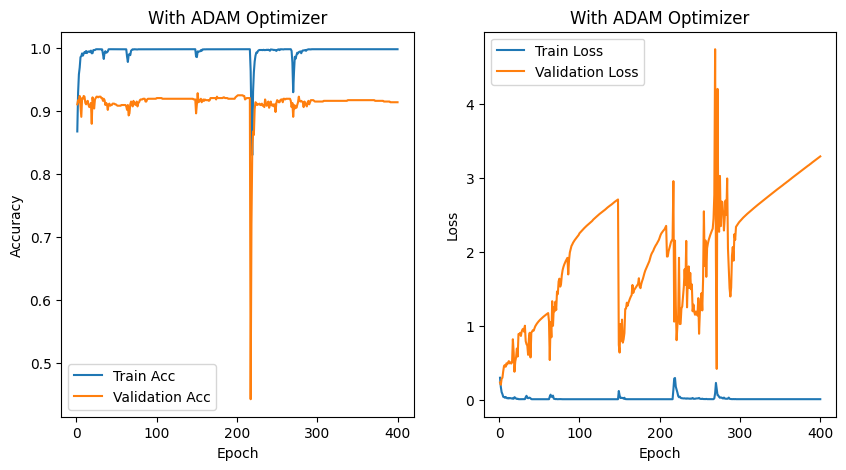

In [40]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }, "With ADAM Optimizer"
)

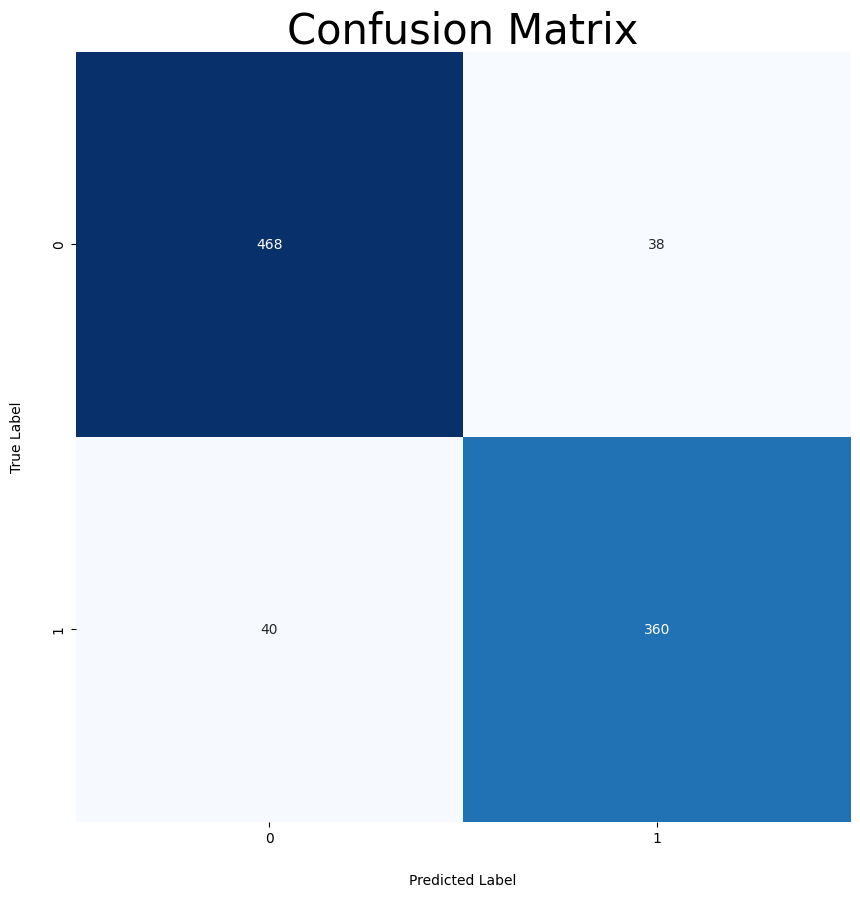

In [41]:
cnn_model_report = generate_confusion_matrix(
    model=cnn_model,
    dataset=valid_dataset,
)

In [42]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(f"Accuracy: {cnn_model_report['accuracy']:.3f}")
print(cnn_model_report['report'])

Recall:    0.912
F1:        0.913
Precision: 0.913
Accuracy: 0.914
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       506
           1       0.90      0.90      0.90       400

    accuracy                           0.91       906
   macro avg       0.91      0.91      0.91       906
weighted avg       0.91      0.91      0.91       906



In [43]:
model = CNN(input_dim=INPUT_DIM, sequence_length=SEQUENCE_LEN, num_classes=NUM_CLASSES)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history_sgd = train_model(
    model=model,
    batch_size=BATCH_SIZE,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device='auto'
)

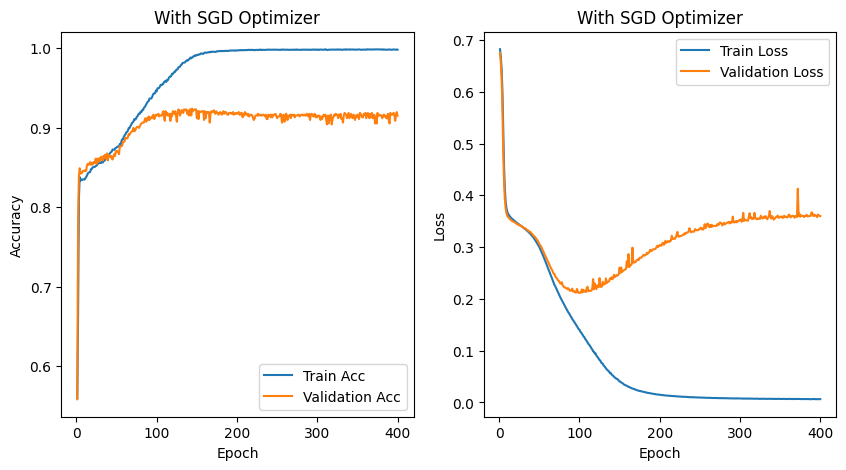

In [44]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", history_sgd["train_acc"]),
            ("Validation Acc", history_sgd["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", history_sgd["train_loss"]),
            ("Validation Loss", history_sgd["valid_loss"])
        ]
    }, "With SGD Optimizer"
)

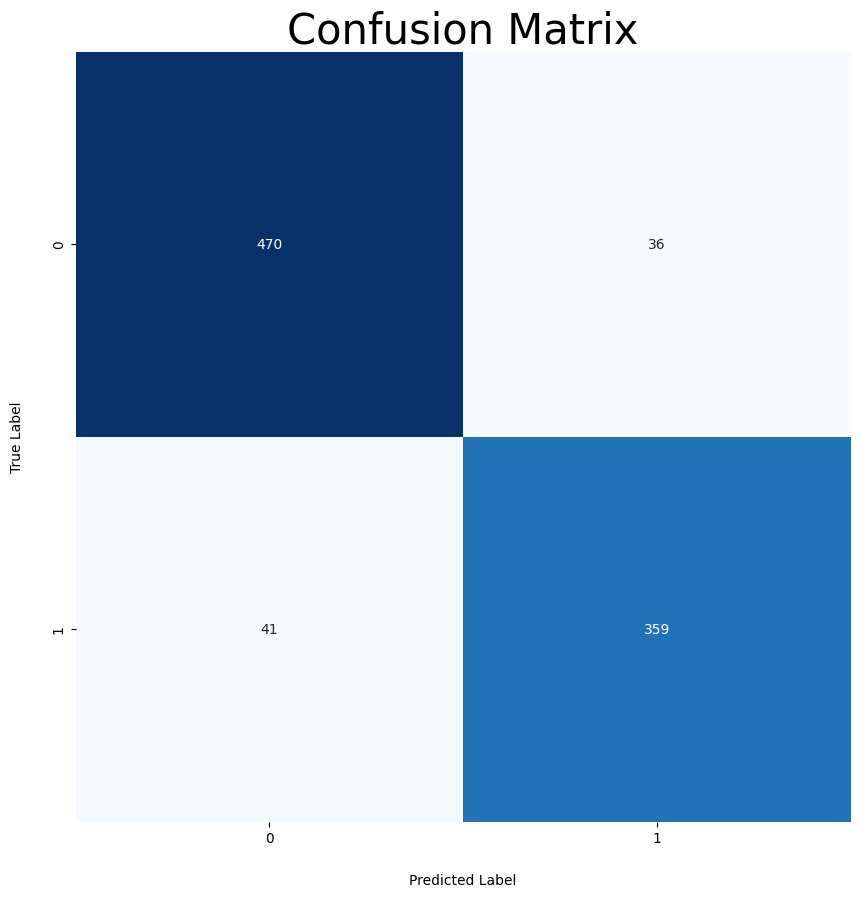

In [45]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=valid_dataset,
)

In [46]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(f"Accuracy: {cnn_model_report['accuracy']:.3f}")
print(cnn_model_report['report'])

Recall:    0.913
F1:        0.914
Precision: 0.914
Accuracy: 0.915
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       506
           1       0.91      0.90      0.90       400

    accuracy                           0.92       906
   macro avg       0.91      0.91      0.91       906
weighted avg       0.91      0.92      0.91       906



### Question 5 : How does ADAM optimizer work and what is it's differences with SGD optimizer?

### How Adam Optimizer Works

The Adam (Adaptive Moment Estimation) optimizer is an extension of the stochastic gradient descent (SGD) that computes adaptive learning rates for each parameter. Adam combines the advantages of two other popular optimization algorithms: AdaGrad and RMSProp.

1. **Initialize Parameters**:
   - $\beta_1, \beta_2$ are decay rates for the moment estimates.
   - $\epsilon$ is a small constant to prevent division by zero.
   - $m_0 = 0$ and $v_0 = 0$.

2. **For each time step $t$**:
   - Compute the gradient $g_t$ of the objective function with respect to the parameters $\theta_t$.

   - Update biased first moment estimate:
     $$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$$
   - Update biased second moment estimate:
     $$v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$$
     
   - Correct bias in first moment:
     $$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
   - Correct bias in second moment:
     $$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
   - Update parameters:
     $$\theta_t = \theta_{t-1} - \frac{\alpha \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

### Key Parameters of Adam
- **Learning rate ($\alpha$)**: Step size for the parameter update.
- **$\beta_1$ and $\beta_2$**: Decay rates for the moving averages of the gradient (typically $\beta_1 = 0.9$ and $\beta_2 = 0.999$).
- **$\epsilon$**: Small constant to avoid division by zero (typically $\epsilon = 10^{-8}$).

### Differences between Adam and SGD

1. **Learning Rate Adaptation**:
   - **SGD**: Uses a single global learning rate for all parameters. The learning rate often needs manual tuning and scheduling (e.g., reducing the learning rate over time).
   - **Adam**: Computes individual adaptive learning rates for different parameters based on the first and second moments of the gradients. This helps in adjusting the learning rate dynamically and often requires less manual tuning.

2. **Gradient Accumulation**:
   - **SGD**: Uses the gradient directly to update the parameters.
   - **Adam**: Maintains and uses exponentially decaying averages of past gradients (first moment) and squared gradients (second moment), which helps in smoother and more informed updates.

3. **Bias Correction**:
   - **SGD**: Directly updates the parameters without any bias correction.
   - **Adam**: Applies bias correction to the first and second moment estimates to account for their initialization at zero, which is particularly important in the early stages of training.

4. **Robustness to Hyperparameters**:
   - **SGD**: Performance is highly sensitive to the choice of learning rate and may require learning rate schedules.
   - **Adam**: Generally more robust to the choice of learning rate and other hyperparameters, making it easier to use without extensive hyperparameter tuning.

In summary, Adam optimizer is particularly well-suited for problems with sparse gradients (e.g., natural language processing and computer vision tasks). It often converges faster and requires less hyperparameter tuning compared to standard SGD. However, Adam can sometimes overfit, and its use might not always lead to better generalization performance compared to well-tuned SGD with momentum. In practice, it's beneficial to experiment with both optimizers and see which one performs better for the specific task and dataset.


### Question 6 : What is cross entropy and why do we use this loss function for our problem according to our problem and dataset(Tweeter problem)?

Cross entropy is a commonly used loss function for classification problems, particularly for binary classification tasks like determining whether a tweet indicates suicidal intent or not.

For binary classification, the cross entropy loss (often referred to as binary cross entropy or log loss) measures the performance of a classification model whose output is a probability value between 0 and 1. It is defined as:

 $$L(y, \hat{y}) = - \frac{1}{N} \sum_{i=1}^N \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$$

Where:
- $ N $ is the number of samples.
- $y_i$ is the true label of sample $i$ (0 for non-suicidal, 1 for suicidal).
- $\hat{y}_i$ is the predicted probability that sample $i$  belongs to the positive class (suicidal).

#### Why Use Cross Entropy Loss?

For our problem of classifying tweets as indicating suicidal intent or not, we need a loss function that effectively measures the difference between the true labels and the predicted probabilities. Cross entropy loss is suitable for this task because:

1. **Probability Distribution**: Cross entropy works with probability distributions, making it ideal for models that output probabilities, like our neural network with a sigmoid activation function in the output layer.
2. **Penalty for Confidence**: It heavily penalizes predictions that are confident and wrong. For instance, if the true label is 1 (suicidal) and the model predicts a probability close to 0, the loss will be very high.
3. **Differentiable**: It is differentiable and works well with gradient-based optimization methods, which are used to train neural networks.

By using cross entropy loss, we ensure that our model's training process focuses on minimizing the difference between the predicted probabilities and the actual labels, leading to a model that is well-calibrated and effective at binary classification.


### Question 7 : What proportion is suitable for our train and test data in this dataset and why?

I have used 90-10 proportion. Here are some reasons :

1. **Maximizing Training Data**:
   - Using 9,000 tweets for training allows the model to learn extensively from a larger dataset. This amount of data is beneficial for capturing the complexities and nuances in the tweets, leading to potentially better model performance.

2. **Sufficient Testing Data**:
   - Using 1,000 tweets for testing provides an adequate evaluation set to measure the model's performance. Even though it is smaller than the training set, it still offers a robust assessment of the model's ability to generalize to unseen data.

3. **Large Dataset**
  - Our dataset is large enough to use 90-10 proportion because in this manner, we can benefit from larger training data (in comparision to 80-20) and a good amount of test data (nearly 1000 data).


4. **Balanced Dataset**
  - The number of suicidal and non-suicidal tweets are nearly eaual in our dataset and thus, it is good to test our data with a good amount of test data with consideration of enough training data to keep our model's bias in a good range.

### Question 8 : What is kernel and what is the effect and result of using it in the layers of convolution? How is it effective in extracting the input features? What is the meaning of the size of kernel being high and low?

A kernel, in the context of convolutional neural networks (CNNs), refers to a small matrix used for filtering input data. When applied to a layer in a CNN, the kernel convolves over the input data, extracting features through element-wise multiplication and summation operations.

#### Effects and Results of Using Kernel in Convolutional Layers:

1. **Feature Extraction**:
   - The primary purpose of using a kernel in convolutional layers is to extract meaningful features from the input data. Each kernel acts as a filter, detecting specific patterns or features such as edges, textures, or shapes.

2. **Localization**:
   - Kernels are localized operators, meaning they focus on a small region of the input data at a time. As the kernel convolves over the input, it scans through different regions, capturing local patterns and structures.

3. **Dimensionality Reduction**:
   - By applying kernels, the spatial dimensions of the input data are often reduced, leading to a more compact representation of the features. This reduction helps in reducing the computational complexity of subsequent layers.

4. **Hierarchical Feature Learning**:
   - As input data passes through multiple convolutional layers with different kernels, the network learns hierarchical representations of features. Lower layers detect basic features like edges and gradients, while deeper layers combine these features to recognize more complex patterns and objects.

#### Effectiveness of Kernel Size:

- **High Kernel Size**:
  - Using a larger kernel size captures more spatial information from the input data in a single convolution operation. This can be beneficial for detecting larger patterns or structures in the data. However, larger kernels also lead to increased model complexity and computational cost.

- **Low Kernel Size**:
  - Smaller kernel sizes focus on capturing finer details and local patterns in the input data. They are effective in detecting smaller features and are computationally less expensive. However, they may struggle to capture global information or larger-scale patterns.

### Question 9 : Why don't we reduce the output of convolutional layers and do this in the feed forward layers? What is the advantages of the feed forward layers to other alternative methods?

1. **Parameter Efficiency**:
   - Fully connected layers have a large number of parameters, especially when the input size is large. By the time the data reaches the fully connected layers, it is beneficial to have reduced the spatial dimensions through pooling, but not excessively. This allows the feedforward layers to operate on a manageable number of features.

2. **Flexibility and Generalization**:
   - The fully connected layers can learn complex, non-linear combinations of features. Reducing dimensionality in these layers helps in avoiding overfitting, as fewer parameters are involved, leading to better generalization.

3. **Hierarchical Feature Learning**:
   - During the convolutional stages, it's crucial to maintain spatial information as much as possible. Excessive reduction in the convolutional layers might lead to loss of important spatial features. Pooling layers provide a balanced way to reduce dimensionality without significant loss of spatial information.

4. **Maintain Spatial Information**:
   - The fully connected layers can learn complex, non-linear combinations of features. Reducing dimensionality in these layers helps in avoiding overfitting, as fewer parameters are involved, leading to better generalization.



## Part 3 : Changing The Size Of Context Window

In [47]:
train_dataset = Twitter(dataframe=train_df, w2v_model=w2v_model, sequence_len=196)
valid_dataset = Twitter(dataframe=test_df, w2v_model=w2v_model, sequence_len=196)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")

Deleted 0-Len Samples: 31
Deleted 0-Len Samples: 6
Train dataset length: 8176
Valid dataset length: 906


In [48]:
class CNN_CW196(nn.Module):
    def __init__(self, input_dim, sequence_length, num_classes):
        super(CNN_CW196, self).__init__()

        self.conv1_3 = nn.Conv1d(in_channels=input_dim, out_channels=196, kernel_size=3, padding=1)
        self.conv1_5 = nn.Conv1d(in_channels=input_dim, out_channels=196, kernel_size=5, padding=2)
        self.conv1_7 = nn.Conv1d(in_channels=input_dim, out_channels=196, kernel_size=7, padding=3)

        self.conv2_3 = nn.Conv1d(in_channels=588, out_channels=128, kernel_size=3, padding=1)
        self.conv2_5 = nn.Conv1d(in_channels=588, out_channels=128, kernel_size=5, padding=2)
        self.conv2_7 = nn.Conv1d(in_channels=588, out_channels=128, kernel_size=7, padding=3)


        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1_input_size = self._calculate_fc1_input_size(input_dim,sequence_length)


        self.fc1 = nn.Linear(18816, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _calculate_fc1_input_size(self, input_dim, sequence_length):
        with torch.no_grad():
            x = torch.zeros(1, sequence_length, input_dim).permute(0, 2, 1)
            x1_3 = F.relu(self.conv1_3(x))
            x1_5 = F.relu(self.conv1_5(x))
            x1_7 = F.relu(self.conv1_7(x))
            x1 = torch.cat((x1_3, x1_5, x1_7), dim=1)
            x1 = self.pool(x1)
            x2_3 = F.relu(self.conv2_3(x1))
            x2_5 = F.relu(self.conv2_5(x1))
            x2_7 = F.relu(self.conv2_7(x1))
            x2 = torch.cat((x2_3, x2_5, x2_7), dim=1)
            x2 = self.pool(x2)
            return x2.numel()

    def forward(self, x):
        x = x.permute(0, 2, 1)

        x1_3 = F.relu(self.conv1_3(x))
        x1_5 = F.relu(self.conv1_5(x))
        x1_7 = F.relu(self.conv1_7(x))
        x1 = torch.cat((x1_3, x1_5, x1_7), dim=1)

        x1 = self.pool(x1)

        x2_3 = F.relu(self.conv2_3(x1))
        x2_5 = F.relu(self.conv2_5(x1))
        x2_7 = F.relu(self.conv2_7(x1))
        x2 = torch.cat((x2_3, x2_5, x2_7), dim=1)

        x2 = self.pool(x2)

        x2 = x2.view(x2.size(0), -1)

        x2 = F.relu(self.fc1(x2))
        x2 = self.fc2(x2)

        return x2


In [49]:
model_cw196 = CNN_CW196(input_dim=INPUT_DIM, sequence_length=SEQUENCE_LEN, num_classes=NUM_CLASSES)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cw196.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

cw196_history = train_model(
    model=model_cw196,
    batch_size=BATCH_SIZE,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device='auto'
)

  0%|          | 0/128 [00:00<?, ?it/s]/home/amin/.local/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


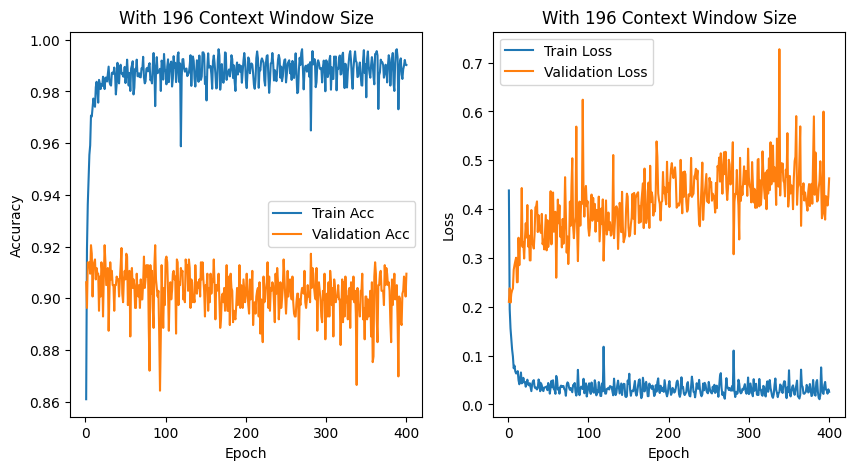

In [50]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cw196_history["train_acc"]),
            ("Validation Acc", cw196_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cw196_history["train_loss"]),
            ("Validation Loss", cw196_history["valid_loss"])
        ]
    }, "With 196 Context Window Size"
)

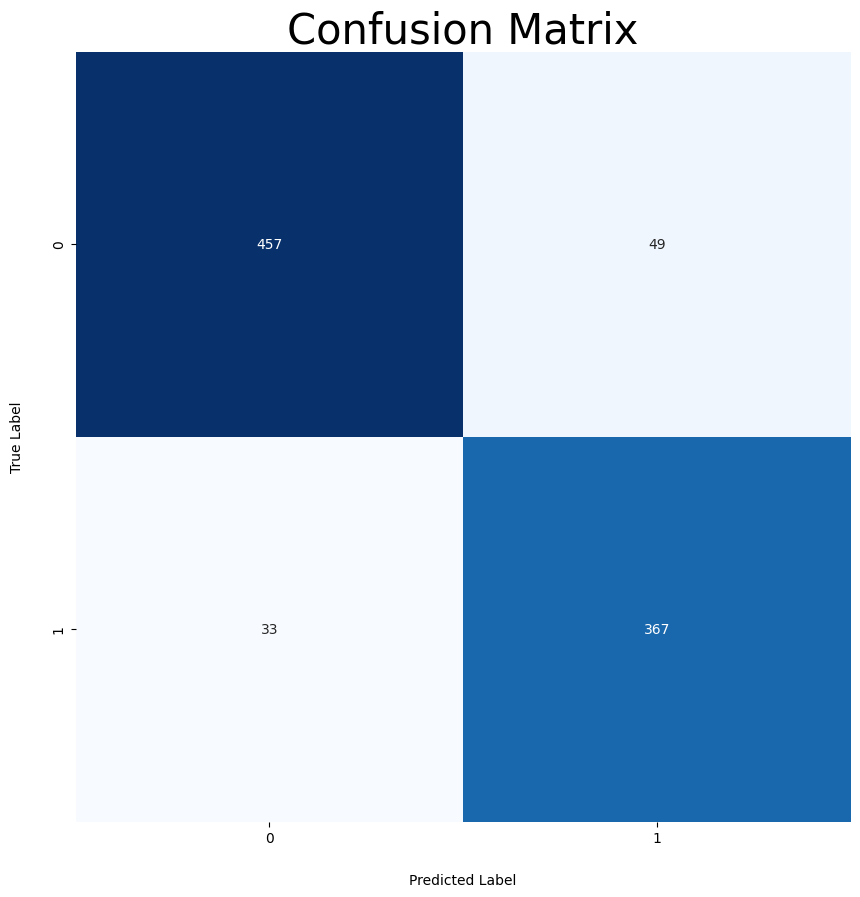

In [51]:
cw196_model_report = generate_confusion_matrix(
    model=model_cw196,
    dataset=valid_dataset,
)

In [52]:
print(f"Recall:    {cw196_model_report['recall']:.3f}")
print(f"F1:        {cw196_model_report['f1']:.3f}")
print(f"Precision: {cw196_model_report['precision']:.3f}")
print(f"Accuracy: {cw196_model_report['accuracy']:.3f}")
print(cw196_model_report['report'])

Recall:    0.910
F1:        0.909
Precision: 0.907
Accuracy: 0.909
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       506
           1       0.88      0.92      0.90       400

    accuracy                           0.91       906
   macro avg       0.91      0.91      0.91       906
weighted avg       0.91      0.91      0.91       906



### Question 10 : What are the pros and cons of increasing the size of context window (such that it is bigger than any tweet's token number) in our CNN model?

#### Pros:

1. **Capture Long-range Dependencies**:
   - A larger context window allows the model to capture long-range dependencies and relationships between words or tokens across a wider span of the input sequence. This can be beneficial for understanding the context and semantics of longer texts, such as tweets.

2. **Enhanced Contextual Understanding**:
   - With a larger context window, the model can consider more surrounding words or tokens when making predictions. This can lead to a more comprehensive understanding of the text's context, enabling the model to make more informed decisions.

3. **Improved Feature Extraction**:
   - Increasing the context window size provides the model with access to more diverse contextual information, which can enhance feature extraction capabilities. This may lead to the discovery of more nuanced patterns and relationships in the input data.

#### Cons:

1. **Increased Computational Complexity**:
   - Larger context windows require processing a greater number of tokens, resulting in increased computational complexity during training and inference. This can lead to longer training times and higher resource requirements.

2. **Risk of Overfitting**:
   - With a larger context window, the model has the potential to memorize specific patterns or noise present in the training data, leading to overfitting. Overfitting occurs when the model learns to perform well on the training data but fails to generalize to unseen data.

3. **Loss of Local Information**:
   - While a larger context window captures more global context, it may also dilute the importance of local information or short-range dependencies within the text. This could result in the model overlooking important local patterns or nuances present in the data.


### Question 11 : Compare the result of increasing context window with the previous context window.

This part take much time longer (approximately 3 times more than previous context window) to train because of the increase in the number of tokens of each sentence. Also the accuracy is slightly better because of the more diversity and number of tokens.

## Part 4 : Applying Regularization

In [53]:
class CNN_Reg(nn.Module):
    def __init__(self, input_dim, sequence_length, num_classes):
        super(CNN_Reg, self).__init__()

        self.conv1_3 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.conv1_5 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=5, padding=2)
        self.conv1_7 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=7, padding=3)

        self.conv2_3 = nn.Conv1d(in_channels=192, out_channels=128, kernel_size=3, padding=1)
        self.conv2_5 = nn.Conv1d(in_channels=192, out_channels=128, kernel_size=5, padding=2)
        self.conv2_7 = nn.Conv1d(in_channels=192, out_channels=128, kernel_size=7, padding=3)

        self.dropout = nn.Dropout(0.5)


        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1_input_size = self._calculate_fc1_input_size(input_dim,sequence_length)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)


        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _calculate_fc1_input_size(self, input_dim, sequence_length):
        with torch.no_grad():
            x = torch.zeros(1, sequence_length, input_dim).permute(0, 2, 1)
            x1_3 = F.relu(self.conv1_3(x))
            x1_5 = F.relu(self.conv1_5(x))
            x1_7 = F.relu(self.conv1_7(x))
            x1 = torch.cat((x1_3, x1_5, x1_7), dim=1)
            x1 = self.pool(x1)
            x2_3 = F.relu(self.conv2_3(x1))
            x2_5 = F.relu(self.conv2_5(x1))
            x2_7 = F.relu(self.conv2_7(x1))
            x2 = torch.cat((x2_3, x2_5, x2_7), dim=1)
            x2 = self.pool(x2)
            return x2.numel()

    def forward(self, x):
        x = x.permute(0, 2, 1)

        x1_3 = F.relu(self.bn1(self.conv1_3(x)))
        x1_5 = F.relu(self.bn1(self.conv1_5(x)))
        x1_7 = F.relu(self.bn1(self.conv1_7(x)))
        x1 = torch.cat((x1_3, x1_5, x1_7), dim=1)
        x1 = self.pool(x1)
        x1 = self.dropout(x1)

        x2_3 = F.relu(self.bn2(self.conv2_3(x1)))
        x2_5 = F.relu(self.bn2(self.conv2_5(x1)))
        x2_7 = F.relu(self.bn2(self.conv2_7(x1)))
        x2 = torch.cat((x2_3, x2_5, x2_7), dim=1)
        x2 = self.pool(x2)
        x2 = self.dropout(x2)

        x2 = x2.view(x2.size(0), -1)

        x2 = F.relu(self.fc1(x2))
        x2 = self.fc2(x2)

        return x2


In [54]:
train_dataset = Twitter(dataframe=train_df, w2v_model=w2v_model, sequence_len=sequence_len)
valid_dataset = Twitter(dataframe=test_df, w2v_model=w2v_model, sequence_len=sequence_len)

Deleted 0-Len Samples: 31
Deleted 0-Len Samples: 6


In [55]:
model_reg = CNN_Reg(input_dim=INPUT_DIM, sequence_length=SEQUENCE_LEN, num_classes=NUM_CLASSES)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_reg.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

cnn_reg_history = train_model(
    model=model_reg,
    batch_size=BATCH_SIZE,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device='auto'
)


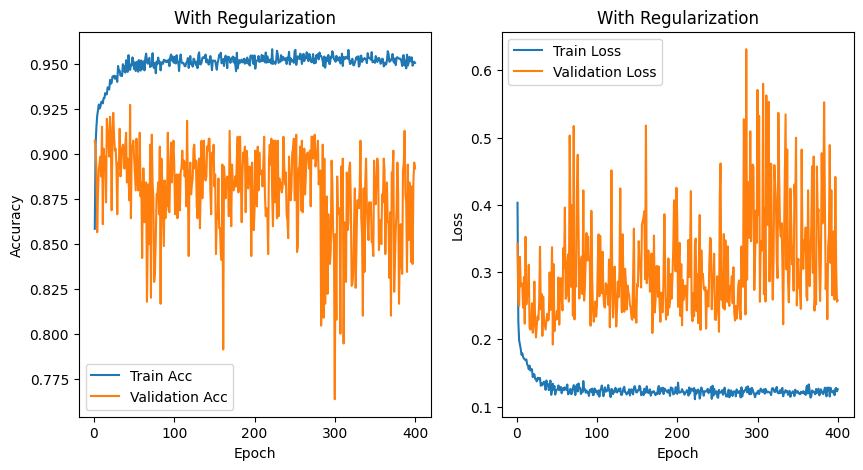

In [56]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_reg_history["train_acc"]),
            ("Validation Acc", cnn_reg_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_reg_history["train_loss"]),
            ("Validation Loss", cnn_reg_history["valid_loss"])
        ]
    }, "With Regularization"
)

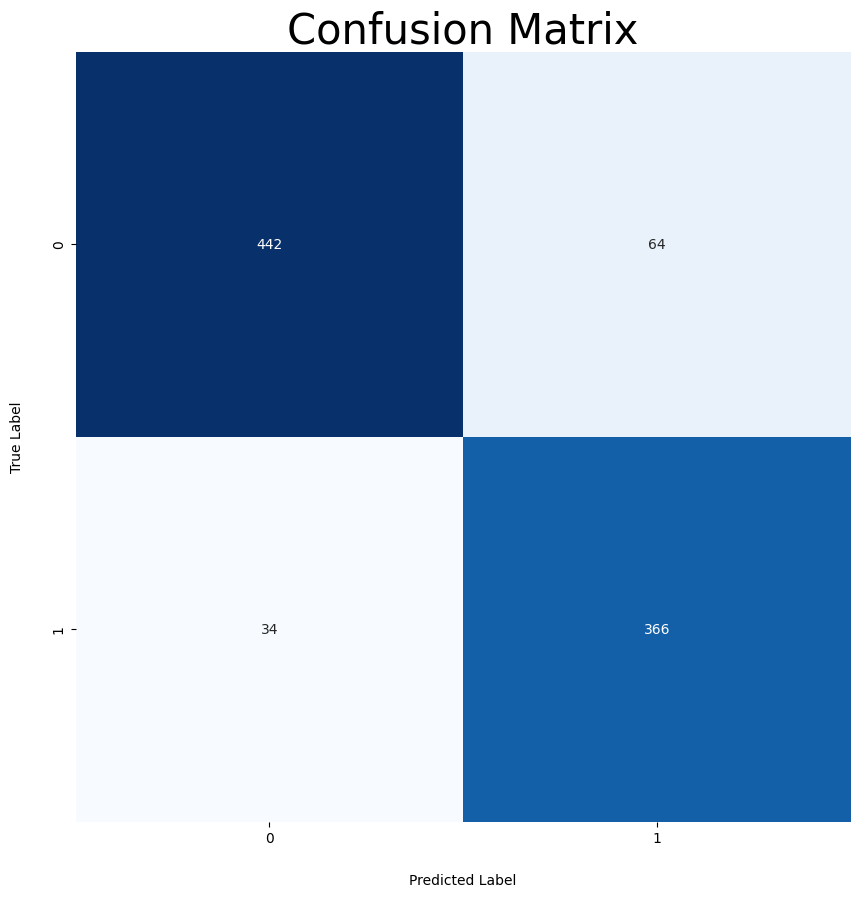

In [57]:
cnn_reg_report = generate_confusion_matrix(
    model=model_reg,
    dataset=valid_dataset,
)

In [58]:
print(f"Recall:    {cnn_reg_report['recall']:.3f}")
print(f"F1:        {cnn_reg_report['f1']:.3f}")
print(f"Precision: {cnn_reg_report['precision']:.3f}")
print(f"Accuracy: {cnn_reg_report['accuracy']:.3f}")
print(cnn_reg_report['report'])

Recall:    0.894
F1:        0.891
Precision: 0.890
Accuracy: 0.892
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       506
           1       0.85      0.92      0.88       400

    accuracy                           0.89       906
   macro avg       0.89      0.89      0.89       906
weighted avg       0.89      0.89      0.89       906



### Question 12 : Compare the results of applying regularization to previous parts.

We can see that the plots of test and train are much closer together and these methods can prevent overfitting. However, in this project our model wasn't overfitting in the previous parts too because of the largeness of our dataset and it's diversity.